In [ ]:
!pip install split-folders

#Import Library

In [ ]:
import os
import gc
import PIL
import pytz
import time
import shutil
import random
import splitfolders
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from datetime import datetime,timezone
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Mount Dari Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load data dan hitung jumlah semua data


In [ ]:
root_folder = '/content/drive/MyDrive/Orbit/Final Project/dataset'

In [ ]:
def find_filepaths(root_folder):
    filepaths = []
    for dirname, _, filenames in os.walk(root_folder):
        for filename in filenames:
            filepaths.append(os.path.join(dirname, filename))
    return filepaths

In [ ]:
filepaths = find_filepaths(root_folder)
total_images = len(filepaths)
print(f"Total gambar = {total_images}")

Total gambar = 931


## Spliting dataset

In [ ]:
input_dir = '/content/drive/MyDrive/Orbit/Final Project/dataset'
output_dir =  '/content/drive/MyDrive/Orbit/Final Project/SplitDataset'

In [ ]:
splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(.8,.1,.1), group_prefix=None)


Copying files: 0 files [00:00, ? files/s]
Copying files: 3 files [00:00,  6.70 files/s]
Copying files: 11 files [00:00, 24.33 files/s]
Copying files: 19 files [00:00, 37.78 files/s]
Copying files: 28 files [00:00, 50.91 files/s]
Copying files: 36 files [00:00, 54.92 files/s]
Copying files: 46 files [00:00, 65.40 files/s]
Copying files: 55 files [00:01, 71.00 files/s]
Copying files: 64 files [00:01, 75.92 files/s]
Copying files: 73 files [00:01, 79.53 files/s]
Copying files: 82 files [00:01, 73.08 files/s]
Copying files: 92 files [00:01, 78.77 files/s]
Copying files: 102 files [00:01, 81.99 files/s]
Copying files: 111 files [00:01, 82.67 files/s]
Copying files: 122 files [00:01, 88.78 files/s]
Copying files: 132 files [00:02, 83.46 files/s]
Copying files: 141 files [00:04, 11.03 files/s]
Copying files: 148 files [00:07,  6.44 files/s]
Copying files: 153 files [00:08,  5.15 files/s]
Copying files: 157 files [00:10,  4.58 files/s]
Copying files: 160 files [00:11,  4.24 files/s]
Copying f

In [ ]:
print(os.listdir(output_dir))

['train', 'val', 'test']


# DATA AUGMENTASI
## Loading and preparing the data
#### 1. `Load the data`
#### 2. `Resize images`
#### 3. `Normalize pixels`

In [ ]:
IMG_SHAPE = (224,224,3) # Required for MobileNet, DenseNet201, VGG16
train_dataset_dir = "/content/drive/MyDrive/Orbit/Final Project/SplitDataset/train"
val_dataset_dir = "/content/drive/MyDrive/Orbit/Final Project/SplitDataset/val"
test_dataset_dir = "/content/drive/MyDrive/Orbit/Final Project/SplitDataset/test"

## Split Data Training 80%

In [ ]:
diseases_classes = os.listdir(train_dataset_dir)
filepaths = find_filepaths(train_dataset_dir)
print(f"----- Training Set Info -----")
print(f"diseases classes = {diseases_classes}")
print(f"Total Kelas Penyakit = {len(diseases_classes)}")
print(f"Total Gambar = {len(filepaths)}")

----- Training Set Info -----
diseases classes = ['Phytopthora', 'Red rust', 'Scab', 'Daun Jambu Sehat', 'Buah Jambu Sehat', 'Antraknosa']
Total Kelas Penyakit = 6
Total Gambar = 742


## Split Data Validation 10%

In [ ]:
diseases_classes = os.listdir(val_dataset_dir)
filepaths = find_filepaths(val_dataset_dir)
print(f"----- Validation Set Info -----")
print(f"diseases classes = {diseases_classes}")
print(f"Total Kelas Penyakit = {len(diseases_classes)}")
print(f"Total Gambar = {len(filepaths)}")

----- Validation Set Info -----
diseases classes = ['Phytopthora', 'Red rust', 'Scab', 'Daun Jambu Sehat', 'Buah Jambu Sehat', 'Antraknosa']
Total Kelas Penyakit = 6
Total Gambar = 89


## Split Data Testing 10%

In [ ]:
diseases_classes = os.listdir(test_dataset_dir)
filepaths = find_filepaths(test_dataset_dir)
print(f"----- Test Set Info -----")
print(f"diseases classes = {diseases_classes}")
print(f"Total Kelas Penyakit = {len(diseases_classes)}")
print(f"Total Gambar = {len(filepaths)}")

----- Test Set Info -----
diseases classes = ['Phytopthora', 'Red rust', 'Scab', 'Daun Jambu Sehat', 'Buah Jambu Sehat', 'Antraknosa']
Total Kelas Penyakit = 6
Total Gambar = 100


## Normalize Pixel dan Resize Gambar

In [ ]:
def min_max_scalar(img, scale_range =(0, 1)):

    px_min = scale_range[0]
    px_max = scale_range[1]
    img = img.astype('float32')
    img = img/img.max()
    scaled_img = img * (px_max - px_min) + px_min
    return scaled_img

def resize(img,size):
    resized_img = img.resize(size, Image.ANTIALIAS)
    resized_img_array = np.asarray(resized_img)
    return resized_img_array

In [ ]:
def load_and_prepare_dataset(dataset_dir,IMG_SHAPE):

    diseases_classes = os.listdir(dataset_dir)

    filepaths = find_filepaths(dataset_dir)
    no_of_total_images = len(filepaths)

    data = np.zeros((no_of_total_images,*IMG_SHAPE),dtype='float32')
    label = []
    ix = 0

    for class_label in diseases_classes:
        class_path = os.path.join(dataset_dir, class_label)
        for img in os.listdir(class_path):
            image = Image.open(os.path.join(class_path, img))
            resized_image = resize(image,IMG_SHAPE[:-1])
            image_array = min_max_scalar(resized_image)
            if image_array.shape == IMG_SHAPE:
                data[ix]=image_array
                label.append(class_label)
            else:
                image_array=np.stack((image_array,)*3, axis=-1)
                data[ix]=image_array
                label.append(class_label)
            ix += 1
    label = np.asarray(label)
    label = label.reshape((-1,1))

    return data,label

In [ ]:
X_train,y_train = load_and_prepare_dataset(train_dataset_dir,IMG_SHAPE)
X_val,y_val = load_and_prepare_dataset(val_dataset_dir,IMG_SHAPE)
X_test,y_test = load_and_prepare_dataset(test_dataset_dir,IMG_SHAPE)

In [ ]:
print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of X_val = {X_val.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (742, 224, 224, 3)
Shape of y_train = (742, 1)
Shape of X_val = (89, 224, 224, 3)
Shape of y_val = (89, 1)
Shape of X_test = (100, 224, 224, 3)
Shape of y_test = (100, 1)


## Visualisasi Gambar Kelas

In [ ]:
def show_unique_images(X,y,idx=0):
    y = np.squeeze(y)
    unique = np.unique(y)
    index=[]
    for i in unique:
        try:
            r = np.where(y==i)
            index.append (r[0][idx])
        except:
            pass

    images=[]
    labels=[]
    for i in index:
        images.append(X[i])
        labels.append(y[i])

    plt.figure(figsize=(16,9))

    for i in range(np.unique(y).size):
        ax = plt.subplot(1,7, i+1)

        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")

    return None


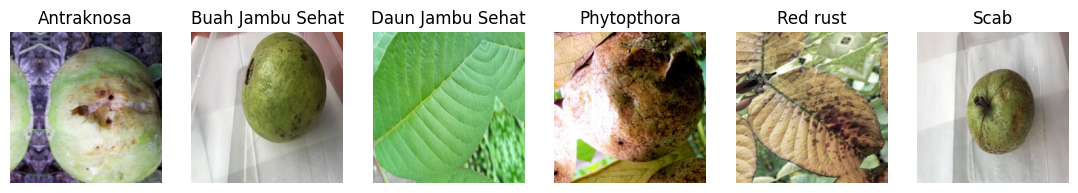

In [ ]:
show_unique_images(X_test,y_test)

## Class distribution sebelum smote

In [ ]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values =Counter(np.squeeze(y_train).tolist()).values()
diseases_count_per_class_before_smote = dict(zip(classes,values))
print(diseases_count_per_class_before_smote)

{'Phytopthora': 133, 'Red rust': 69, 'Scab': 188, 'Daun Jambu Sehat': 100, 'Buah Jambu Sehat': 175, 'Antraknosa': 77}


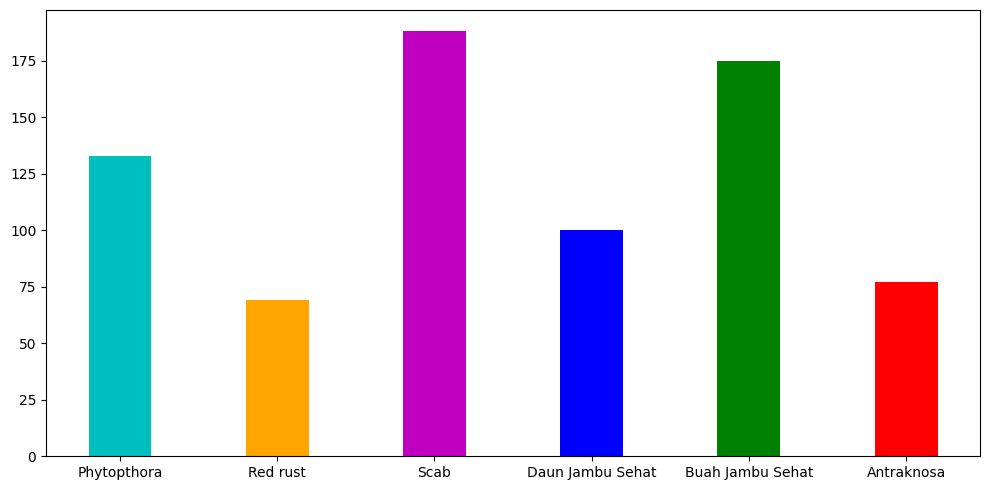

In [ ]:
fig = plt.figure(figsize = (10, 5))

diseases_names = list(diseases_count_per_class_before_smote.keys())
diseases_counts = list(diseases_count_per_class_before_smote.values())
plt.bar(diseases_names,diseases_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()

## Menerapkan SMOTE untuk menghilangkan data imbalance

In [ ]:
# Reshaping is important for feeding the data into fit_resample method of SMOTE class
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
print(f"Shape of data is {X_train.shape}")
print(f"Shape of label is {y_train.shape}")
print(f"Data type of data is {type(X_train)}")
print(f"Data type of label is {type(y_train)}")

Shape of data is (742, 150528)
Shape of label is (742, 1)
Data type of data is <class 'numpy.ndarray'>
Data type of label is <class 'numpy.ndarray'>


In [ ]:
smote = SMOTE(random_state=42)
X_train = X_train.reshape((-1,IMG_SHAPE[0]*IMG_SHAPE[1]*IMG_SHAPE[2]))
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (1128, 150528)
Shape of y_train : (1128,)


In [ ]:
X_train = X_train.reshape((-1,*IMG_SHAPE))
y_train = y_train.reshape((-1,1))
print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of y_train : {y_train.shape}")

Shape of X_train : (1128, 224, 224, 3)
Shape of y_train : (1128, 1)


## Class distribution setelah smote

In [ ]:
classes = Counter(np.squeeze(y_train).tolist()).keys()
values =Counter(np.squeeze(y_train).tolist()).values()
diseases_count_per_class_after_smote = dict(zip(classes,values))
print(diseases_count_per_class_after_smote)

{'Phytopthora': 188, 'Red rust': 188, 'Scab': 188, 'Daun Jambu Sehat': 188, 'Buah Jambu Sehat': 188, 'Antraknosa': 188}


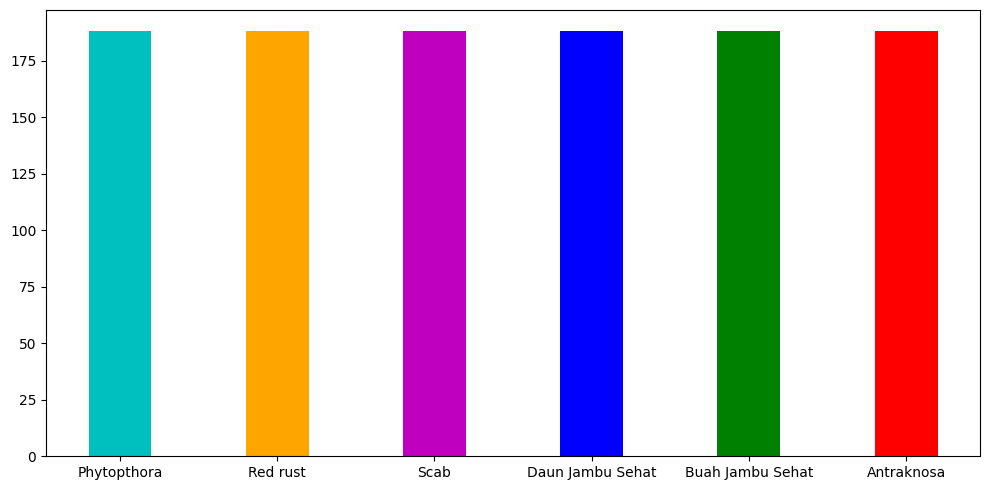

In [ ]:
fig = plt.figure(figsize = (10, 5))

diseases_names = list(diseases_count_per_class_after_smote.keys())
diseases_counts = list(diseases_count_per_class_after_smote.values())
plt.bar(diseases_names,diseases_counts,color =['c','orange','m','b','g','r','maroon'],width = 0.4)
plt.tight_layout()

#Pre-Processing Dataset

In [ ]:
# One hot encoding
def one_hot_encoder(array):
    encoded_array = []
    unique = np.unique(array)
    for item in array:
        encoded_item = item == unique
        encoded_array.append(encoded_item)
    encoded_array = np.asarray(encoded_array)
    encoded_array = encoded_array.astype(int)
    return encoded_array

In [ ]:
y_train_encoded = one_hot_encoder(y_train)
y_val_encoded = one_hot_encoder(y_val)
y_test_encoded = one_hot_encoder(y_test)

In [ ]:
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_train_encoded = {y_train_encoded.shape}")
print(f"Shape of y_val = {y_val.shape}")
print(f"Shape of y_val_encoded = {y_val_encoded.shape}")
print(f"Shape of y_test = {y_test.shape}")
print(f"Shape of y_test_encoded = {y_test_encoded.shape}")

Shape of y_train = (1128, 1)
Shape of y_train_encoded = (1128, 6)
Shape of y_val = (89, 1)
Shape of y_val_encoded = (89, 6)
Shape of y_test = (100, 1)
Shape of y_test_encoded = (100, 6)


## Import Library

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,LeakyReLU, GlobalAveragePooling2D

#Arsitekture MobileNet

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

In [ ]:
BaseModel = MobileNet(weights='imagenet', include_top=False, input_shape= IMG_SHAPE )

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(6, activation="softmax" , name="classification"))

In [ ]:
from keras import backend as K

In [ ]:
# Evaluation Metrics for Callback
def get_recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def get_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred):
    precision = get_precision(y_true, y_pred)
    recall = get_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004,momentum=0.9),
            loss='categorical_crossentropy',
            metrics = ['accuracy',get_f1,get_precision,get_recall], )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 6)                 3

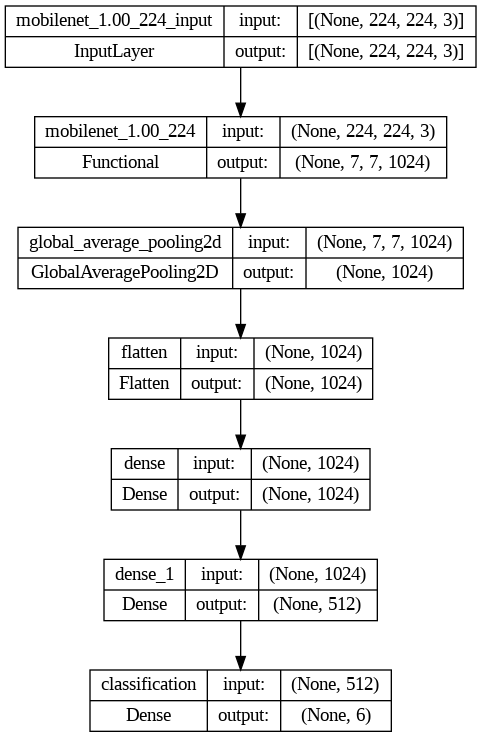

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='MobileNet_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Check if all the shapes are ok
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(1128, 224, 224, 3)
(1128, 6)
(89, 224, 224, 3)
(89, 6)


In [ ]:
history = model.fit(X_train,y_train_encoded,
                    validation_data=(X_val,y_val_encoded),
                    batch_size=32, epochs=30)

Epoch 1/30
36/36 [==============================] - 27s 170ms/step - loss: 1.2238 - accuracy: 0.6418 - get_f1: 0.2822 - get_precision: 0.7277 - get_recall: 0.1997 - val_loss: 0.8599 - val_accuracy: 0.7640 - val_get_f1: 0.6333 - val_get_precision: 0.9438 - val_get_recall: 0.5021
Epoch 2/30
36/36 [==============================] - 4s 111ms/step - loss: 0.4512 - accuracy: 0.9246 - get_f1: 0.8752 - get_precision: 0.9791 - get_recall: 0.7969 - val_loss: 0.4796 - val_accuracy: 0.8989 - val_get_f1: 0.8205 - val_get_precision: 0.9815 - val_get_recall: 0.7163
Epoch 3/30
36/36 [==============================] - 4s 110ms/step - loss: 0.2380 - accuracy: 0.9707 - get_f1: 0.9606 - get_precision: 0.9829 - get_recall: 0.9401 - val_loss: 0.3060 - val_accuracy: 0.9326 - val_get_f1: 0.9076 - val_get_precision: 0.9867 - val_get_recall: 0.8425
Epoch 4/30
36/36 [==============================] - 4s 107ms/step - loss: 0.1563 - accuracy: 0.9770 - get_f1: 0.9710 - get_precision: 0.9827 - get_recall: 0.9601 - v

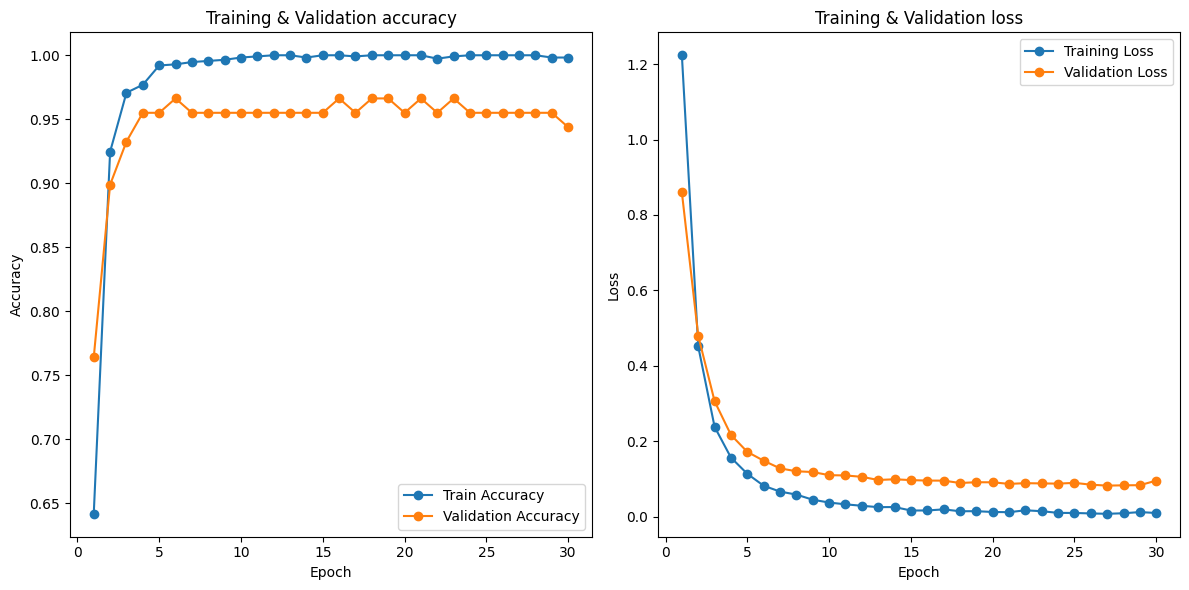

In [ ]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

    return None

plot_accuracy_loss(history)

In [ ]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

4/4 [==============================] - 0s 132ms/step - loss: 0.1795 - accuracy: 0.9600 - get_f1: 0.9688 - get_precision: 0.9688 - get_recall: 0.9688
[0.17949742078781128, 0.9599999785423279, 0.96875, 0.96875, 0.96875]


In [ ]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

4/4 [==============================] - 1s 42ms/step
[0 3 3 3 0 3 3 3 0 3 3 0 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def label_encoder(string):
    diseases_classes = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
    for i,diseases in enumerate(diseases_classes):
        if string == diseases:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85        11
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        14
           3       1.00      0.78      0.88        18
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        24

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.95       100
weighted avg       0.97      0.96      0.96       100



In [ ]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

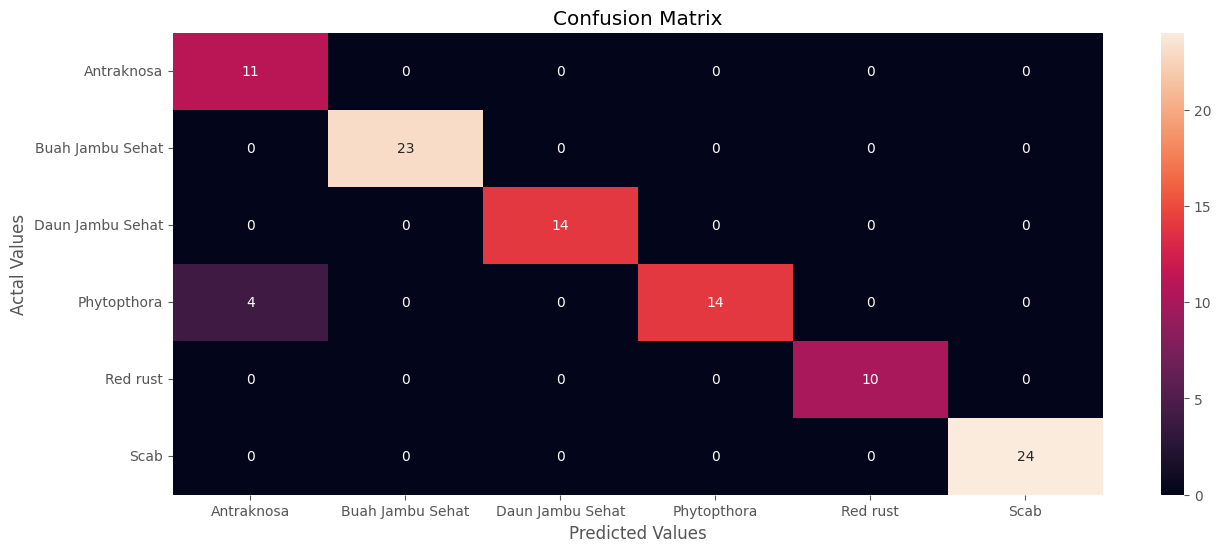

In [ ]:
labels = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

In [ ]:
from tensorflow.keras.models import load_model
# Save the weights
model.save_weights('/content/drive/MyDrive/Orbit/Final Project/saved_models/MobileNet-SGD_96_Model.h5')

#Arsitekture Densenet201

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet201

In [ ]:
BaseModel = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

In [ ]:
model = Sequential()

model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(6, activation="softmax" , name="classification"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004,momentum=0.9),
            loss='categorical_crossentropy',
            metrics = ['accuracy',get_f1,get_precision,get_recall])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_3 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              1967104   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 6)                 3078      
                                                      

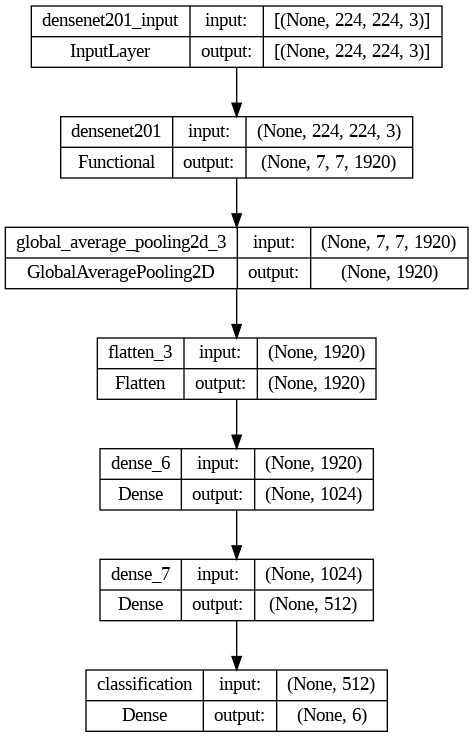

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='MobileNet_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Check if all the shapes are ok
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(1128, 224, 224, 3)
(1128, 6)
(89, 224, 224, 3)
(89, 6)


In [ ]:
history = model.fit(X_train,y_train_encoded,
                    validation_data=(X_val,y_val_encoded),
                    batch_size=32, epochs=30)

Epoch 1/30
36/36 [==============================] - 80s 644ms/step - loss: 1.2776 - accuracy: 0.6312 - get_f1: 0.2508 - get_precision: 0.5556 - get_recall: 0.1736 - val_loss: 0.9201 - val_accuracy: 0.7191 - val_get_f1: 0.5495 - val_get_precision: 0.8971 - val_get_recall: 0.4321
Epoch 2/30
36/36 [==============================] - 19s 514ms/step - loss: 0.4393 - accuracy: 0.9344 - get_f1: 0.8604 - get_precision: 0.9894 - get_recall: 0.7682 - val_loss: 0.4807 - val_accuracy: 0.9438 - val_get_f1: 0.8411 - val_get_precision: 1.0000 - val_get_recall: 0.7458
Epoch 3/30
36/36 [==============================] - 19s 524ms/step - loss: 0.2019 - accuracy: 0.9849 - get_f1: 0.9662 - get_precision: 0.9965 - get_recall: 0.9401 - val_loss: 0.2856 - val_accuracy: 0.9888 - val_get_f1: 0.9452 - val_get_precision: 1.0000 - val_get_recall: 0.9004
Epoch 4/30
36/36 [==============================] - 19s 521ms/step - loss: 0.1132 - accuracy: 0.9929 - get_f1: 0.9881 - get_precision: 0.9965 - get_recall: 0.9800 

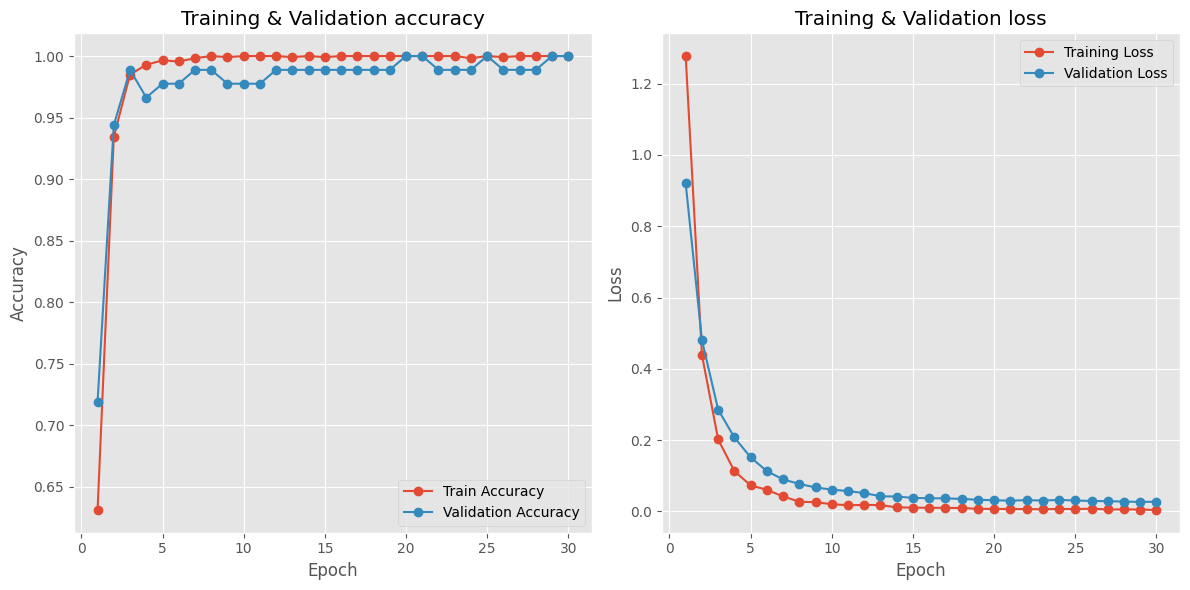

In [ ]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

    return None

plot_accuracy_loss(history)

In [ ]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

4/4 [==============================] - 1s 115ms/step - loss: 0.0787 - accuracy: 0.9800 - get_f1: 0.9844 - get_precision: 0.9844 - get_recall: 0.9844
[0.07868632674217224, 0.9800000190734863, 0.984375, 0.984375, 0.984375]


In [ ]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

4/4 [==============================] - 4s 144ms/step
[3 3 3 3 0 3 3 3 3 3 3 3 0 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def label_encoder(string):
    diseases_classes = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
    for i,diseases in enumerate(diseases_classes):
        if string == diseases:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        14
           3       1.00      0.89      0.94        18
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        24

    accuracy                           0.98       100
   macro avg       0.97      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [ ]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

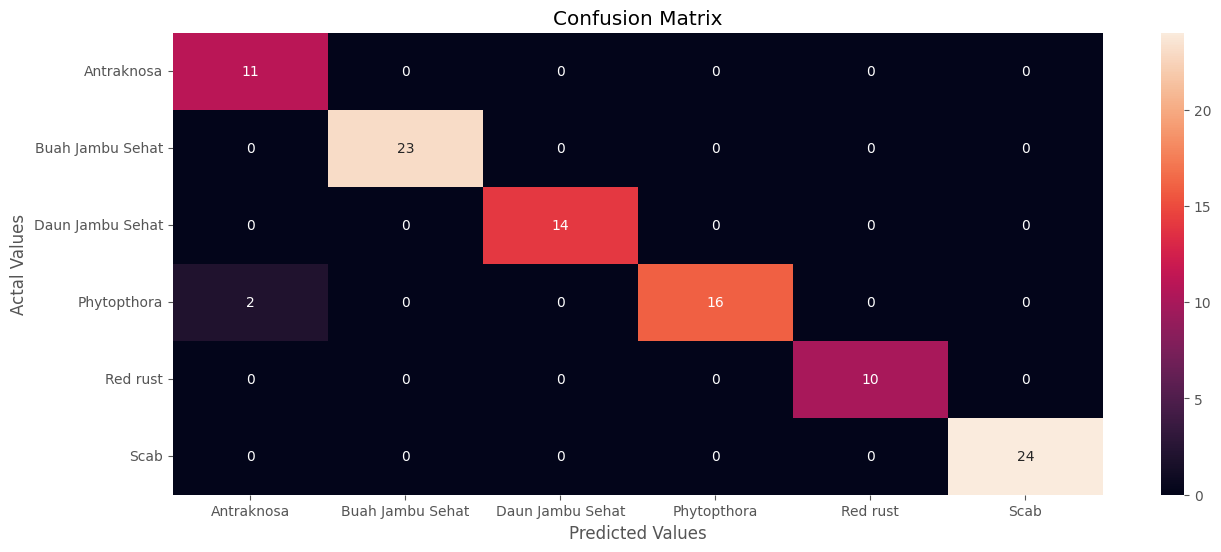

In [ ]:
labels = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

In [ ]:
from tensorflow.keras.models import load_model
# Save the weights
model.save_weights('/content/drive/MyDrive/Orbit/Final Project/saved_models/DenseNet201-SGD_98_Model.h5')

#Arsitekture VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
BaseModel = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

In [ ]:
model = Sequential()

model.add(BaseModel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(6, activation="softmax" , name="classification"))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0004,momentum=0.9),
            loss='categorical_crossentropy',
            metrics = ['accuracy',get_f1,get_precision,get_recall])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 6)                 3078      
                                                      

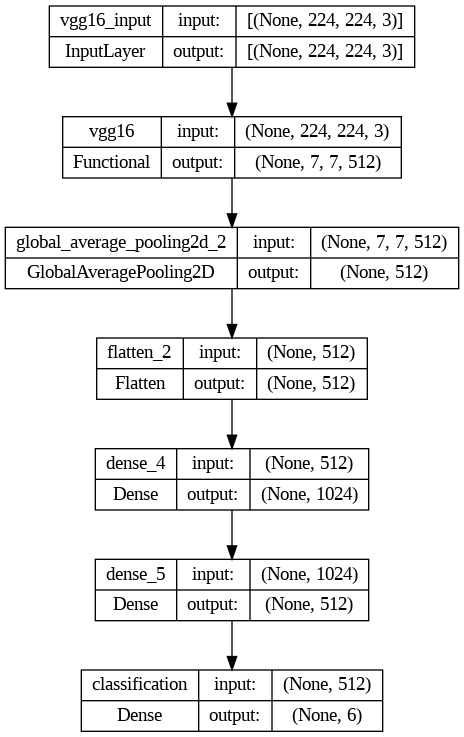

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='MobileNet_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Check if all the shapes are ok
print(X_train.shape[0]==y_train_encoded.shape[0])
print(type(X_train) == type(y_train_encoded))
print(X_train.shape)
print(y_train_encoded.shape)
print(X_val.shape)
print(y_val_encoded.shape)

True
True
(1128, 224, 224, 3)
(1128, 6)
(89, 224, 224, 3)
(89, 6)


In [ ]:
history = model.fit(X_train,y_train_encoded,
                    validation_data=(X_val,y_val_encoded),
                    batch_size=32, epochs=30)

Epoch 1/30
36/36 [==============================] - 18s 419ms/step - loss: 1.6597 - accuracy: 0.3821 - get_f1: 0.0000e+00 - get_precision: 0.0000e+00 - get_recall: 0.0000e+00 - val_loss: 1.4322 - val_accuracy: 0.5506 - val_get_f1: 0.0000e+00 - val_get_precision: 0.0000e+00 - val_get_recall: 0.0000e+00
Epoch 2/30
36/36 [==============================] - 15s 407ms/step - loss: 0.8503 - accuracy: 0.6924 - get_f1: 0.5275 - get_precision: 0.7076 - get_recall: 0.4653 - val_loss: 0.6270 - val_accuracy: 0.8090 - val_get_f1: 0.7367 - val_get_precision: 0.8061 - val_get_recall: 0.6846
Epoch 3/30
36/36 [==============================] - 15s 418ms/step - loss: 0.4422 - accuracy: 0.8608 - get_f1: 0.8530 - get_precision: 0.8980 - get_recall: 0.8142 - val_loss: 0.3594 - val_accuracy: 0.8764 - val_get_f1: 0.8562 - val_get_precision: 0.9005 - val_get_recall: 0.8171
Epoch 4/30
36/36 [==============================] - 15s 404ms/step - loss: 0.3466 - accuracy: 0.8910 - get_f1: 0.8871 - get_precision: 0.91

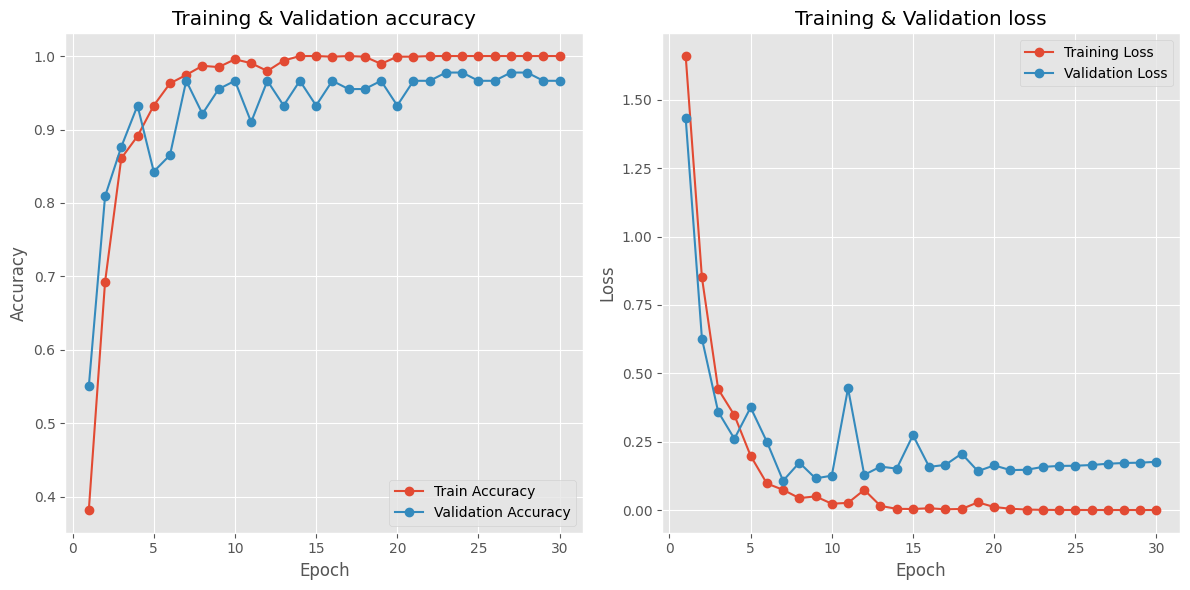

In [ ]:
def plot_accuracy_loss(history):
    f,ax = plt.subplots(1,2,figsize=(12,6))

    ax[0].plot([None]+history.history['accuracy'],'o-')
    ax[0].plot([None]+history.history['val_accuracy'],'o-')
    ax[0].legend(['Train Accuracy','Validation Accuracy'],loc = 0)
    ax[0].set_title('Training & Validation accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot([None]+history.history['loss'],'o-')
    ax[1].plot([None]+history.history['val_loss'],'o-')
    ax[1].legend(['Training Loss','Validation Loss'],loc = 0)
    ax[1].set_title('Training & Validation loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')

    plt.style.use('ggplot')
    plt.tight_layout()
    plt.show()

    return None

plot_accuracy_loss(history)

In [ ]:
result = model.evaluate(X_test,y_test_encoded)
print(result)

4/4 [==============================] - 0s 94ms/step - loss: 0.2030 - accuracy: 0.9700 - get_f1: 0.9766 - get_precision: 0.9766 - get_recall: 0.9766
[0.20297406613826752, 0.9700000286102295, 0.9765625, 0.9765625, 0.9765625]


In [ ]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print(predictions)

4/4 [==============================] - 1s 112ms/step
[0 3 3 3 3 3 3 3 0 3 3 5 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
def label_encoder(string):
    diseases_classes = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
    for i,diseases in enumerate(diseases_classes):
        if string == diseases:
            return i
y_test_enc = np.asarray(list(map(label_encoder,np.squeeze(y_test).tolist())))
print(y_test_enc)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
print(classification_report(y_test_enc,predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        14
           3       1.00      0.83      0.91        18
           4       1.00      1.00      1.00        10
           5       0.96      1.00      0.98        24

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [ ]:
def display_confusion_matrix(confusion_matrix,labels):
    conf_matrix_df = pd.DataFrame(confusion_matrix,
                         index = labels,
                         columns = labels)
    plt.figure(figsize=(15,6))
    sns.heatmap(conf_matrix_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    return None

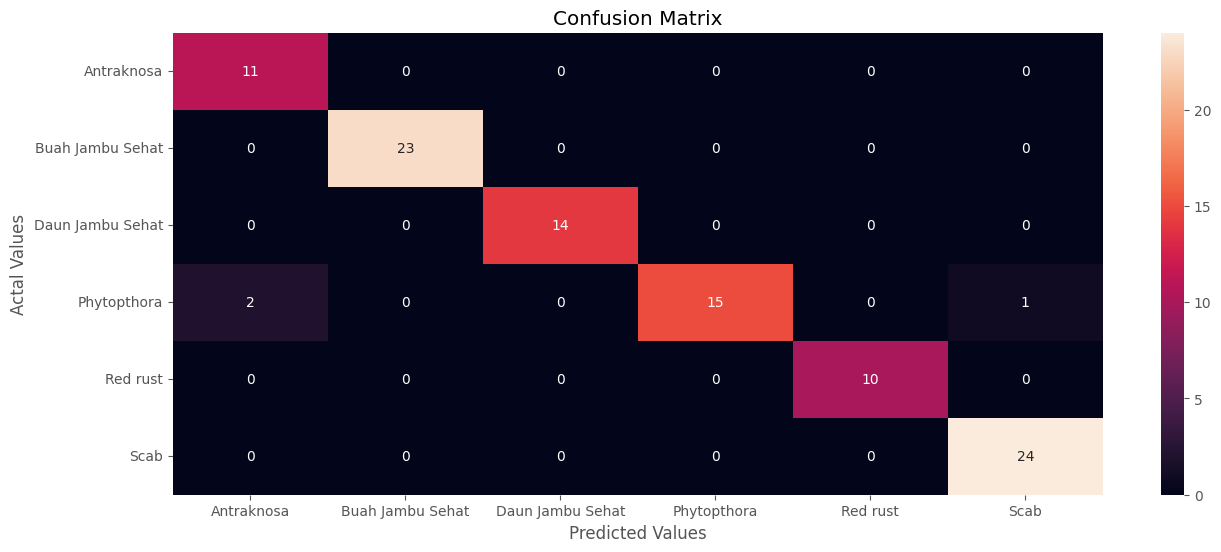

In [ ]:
labels = ['Antraknosa','Buah Jambu Sehat', 'Daun Jambu Sehat', 'Phytopthora', 'Red rust', 'Scab']
conf_matrix = confusion_matrix(y_test_enc,predictions)
display_confusion_matrix(conf_matrix,labels)

## Save and Load Model

In [ ]:
from tensorflow.keras.models import load_model
# Save the weights
model.save_weights('/content/drive/MyDrive/Orbit/Final Project/saved_models/VGG16-SGD_97_Model.h5')

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Orbit/Final Project/saved_models/DenseNet201-SGD_98_Model.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1967104   
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 classification (Dense)      (None, 6)                 3078      
                                                      

#Model Predict

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
image = load_img('/content/drive/MyDrive/Orbit/Phytopthora.jpg', target_size=(224, 224))
img = np.array(image)
img = img / 255.0
img = img.reshape(1,224,224,3)

In [ ]:
# Prediksi untuk Data Latih
y_pred_train            = model.predict(img)
y_pred_train_classes    = np.argmax(y_pred_train)
y_pred_train_max_probas = np.max(y_pred_train)

1/1 [==============================] - 18s 18s/step


In [ ]:
print(y_pred_train)
print(y_pred_train_classes)
print(y_pred_train_max_probas)

[[5.6579622e-04 1.3012365e-03 9.8521334e-01 2.9121737e-03 3.7215580e-03
  6.2857890e-03]]
2
0.98521334
